In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate

def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

modelLoads= ["AB", "BA", "BB", "infer2018", "AsA"]
weightModels= ["degree", "gravity", "identical", "none"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
soleGraphs= ["ba1", "ba2", "ba3", "er1", "er2", "er3"]
realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
realGraphs= [ "mobility_german", "mobility_us"]
realGraphs= ["global_air", "us_air"]
realGraphs= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]

seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [-3, -4]
nodes= [50, 200, 400]
intenses= [0, 1, 2]

identicalfs= [5e-4, 1e-3, 2e-3, 5e-3, 2e-2, 5e-2, 1e-1]# except 1e-2
identicalfsAdd= [2e-4]


commands1=set()
linuxThread= 4

In [2]:
#AsA 

for randomGraph in randomGraphs:
    for seed in seeds:
        command= f"python run.py --epoches {150000} --modelLoad AsA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains {4}  --dense {0} --n {100} --intense {-1} --identicalf {0.01}"
        commands1.add(command)

In [2]:
#Performance on sole graphs new 4*5*4*4=320
count2= 0
for soleGraph in realGraphs:
    for strain in strains:
        count2+=1
        command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {soleGraph}\
        --seed {11} --strains {strain}  --dense {0} --n {100} --intense {-1}"
        commands1.add(command)


In [2]:
#Performance on different models new 4*5*4*4=320
count2= 0
for randomGraph in randomGraphs:
    for seed in seeds:
        for modelL in ["AA"]:
            for strain in strains:
                count2+=1
                command= f"python run.py --epoches {150000} --modelLoad {modelL} --weightModel identical --randomGraph {randomGraph}\
                --seed {seed} --strains {strain}  --dense {0} --n {100} --intense {-1}"
                commands1.add(command)


In [ ]:
#Performance on different strains new
for randomGraph in randomGraphs:
    for seed in seeds:
        for strain in strains:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
              --seed {seed} --strains {strain}  --dense {0} --n {100} --intense {-1}"
            commands1.add(command)

In [ ]:
#optimial identical f gross

for randomGraph in randomGraphs:
    for seed in seeds:
        for identicalf in identicalfsAdd:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
              --seed {seed} --strains {4}  --dense {0} --n {100} --intense {-1} --identicalf {identicalf}"
            commands1.add(command)

In [3]:
#Performance on different node number
for randomGraph in randomGraphs:
    for seed in seeds:
        for node in nodes:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {0} --n {node} --intense {-1} --identicalf {0.01}"
            commands1.add(command)

In [4]:
#Performance on different intense
for randomGraph in randomGraphs:
    for seed in seeds:
        for intsense in intenses:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {0} --n 100 --intense {intsense} --identicalf {0.01}"
            commands1.add(command)

In [ ]:
#Performance on different dense
for randomGraph in randomGraphs:
    for seed in seeds:
        for dense in denses:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {dense} --n 100 --intense -1 --identicalf {0.01}"
            commands1.add(command)

In [3]:
count=0
with open("myCommands.sh", 'w') as file:
    # Write each element on a new line
    for i, string in enumerate(commands1):
        file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
        file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1} &\n")
        count+=1
        if count%linuxThread==0:
            file.write("wait\n")
    if count%linuxThread !=0:
        file.write("wait\n")

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import modules.plotGraph as plotGraph
import networkx as nx
from matplotlib.colors import Normalize

IMatrixNp= np.eye(50)

maxValue= 0

def load_npz_matrix(fileName, maxValue):
    npzfile = np.load(fileName)
    # Access the arrays in the NPZ file
    Aw = npzfile['A']
    PreA = npzfile['Apre']
    tempMax= np.max(PreA)
    if maxValue<tempMax:
        maxValue=tempMax
    return Aw, PreA, maxValue

#AA_WS_identical_11_4_-1_0_100_10.0_150000

PreAs=[]
Aws= []
links= []
randomGraph= "RGG"
realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400"]
# realGraphs3= ["spain_plane", "spain_bus", "spain_car", "spain_train"]
realGraphs3= ["contious_usa", "contious_china", "contious_EU", "contious_Africa"]
realGraphs3= ["global_air"]
seed= 11
jaccardSims= []
mappings= []
for i, item in enumerate(strains):
    gmodel= "us_air400"
    fileName= f"results/AA/AA_{gmodel}_identical_{seed}_{item}_-1_0_100_{0.01*1000}_150000.npz"
    Aw, PreA, maxValue= load_npz_matrix(fileName, maxValue)
    link= int((np.sum(Aw))/0.01)

    # Gref= nx.read_graphml("graphs2/"+item+".graphml")
    # G= nx.from_numpy_array(Aw*100)
    # matcher = nx.isomorphism.GraphMatcher(G, Gref)
    # print(matcher.is_isomorphic())
    # mappings.append(matcher.mapping)
    jaccardSim= evaluate.jaccard_similarity(torch.tensor(Aw), torch.tensor(PreA))
    jaccardSims.append(round(jaccardSim.item(), 2))
    links.append(link)
    Aws.append(Aw)
    PreAs.append(PreA)

PreAsp= [continious_to_sparcity(item, links[i]) for i, item in enumerate(PreAs)]
campThis= "viridis"

# plotGraph.plot_adjacenty(Aws[0], [PreAs[3]])

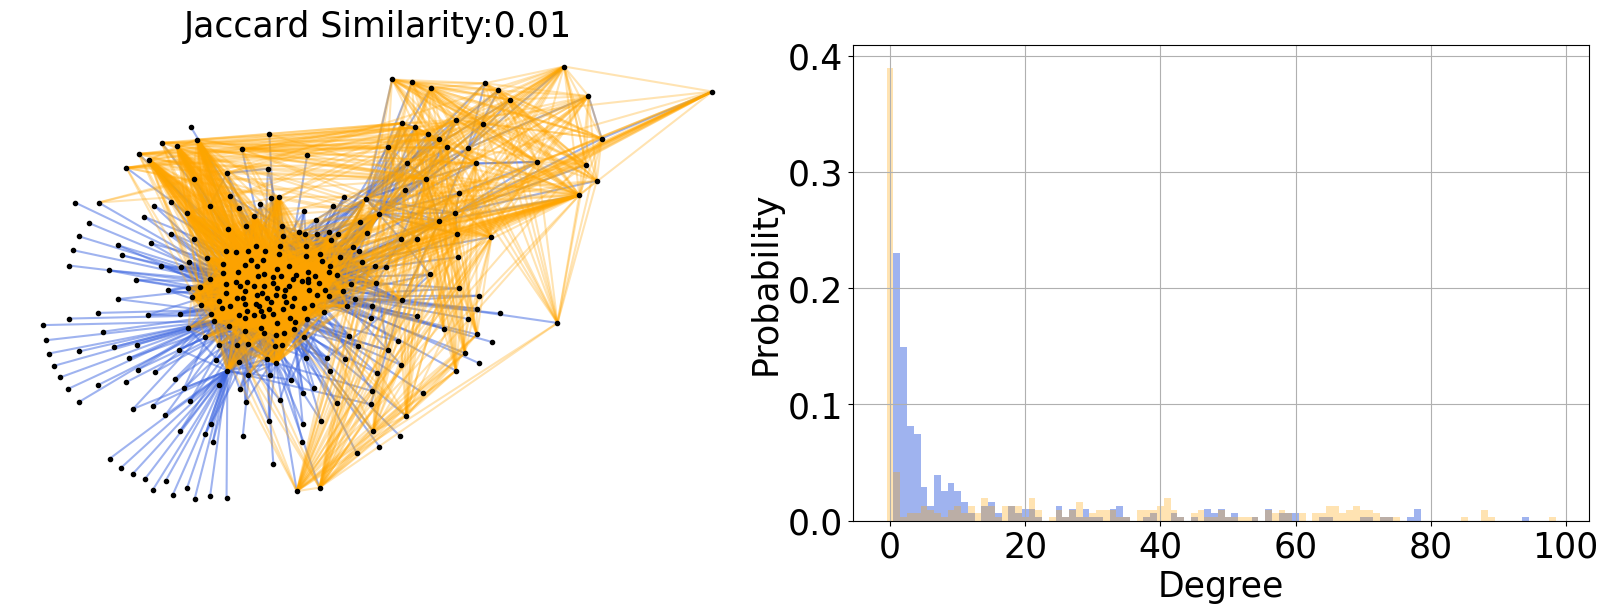

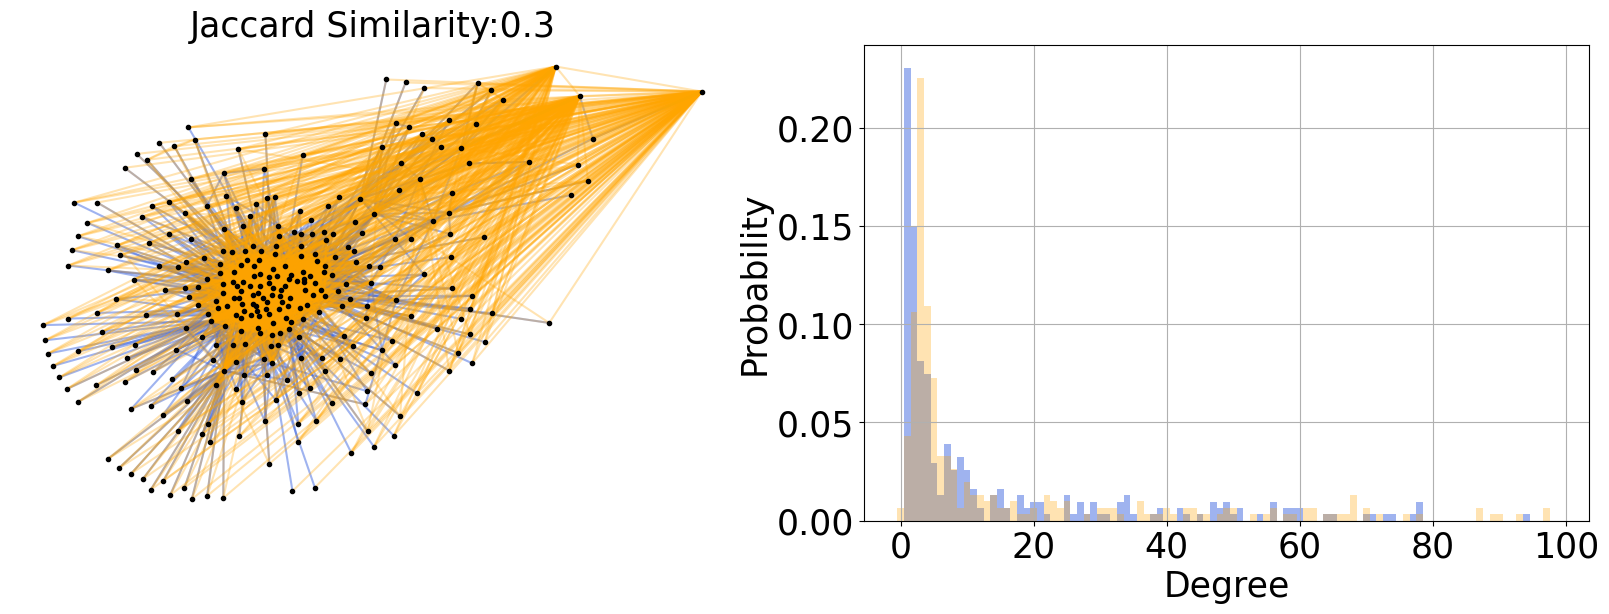

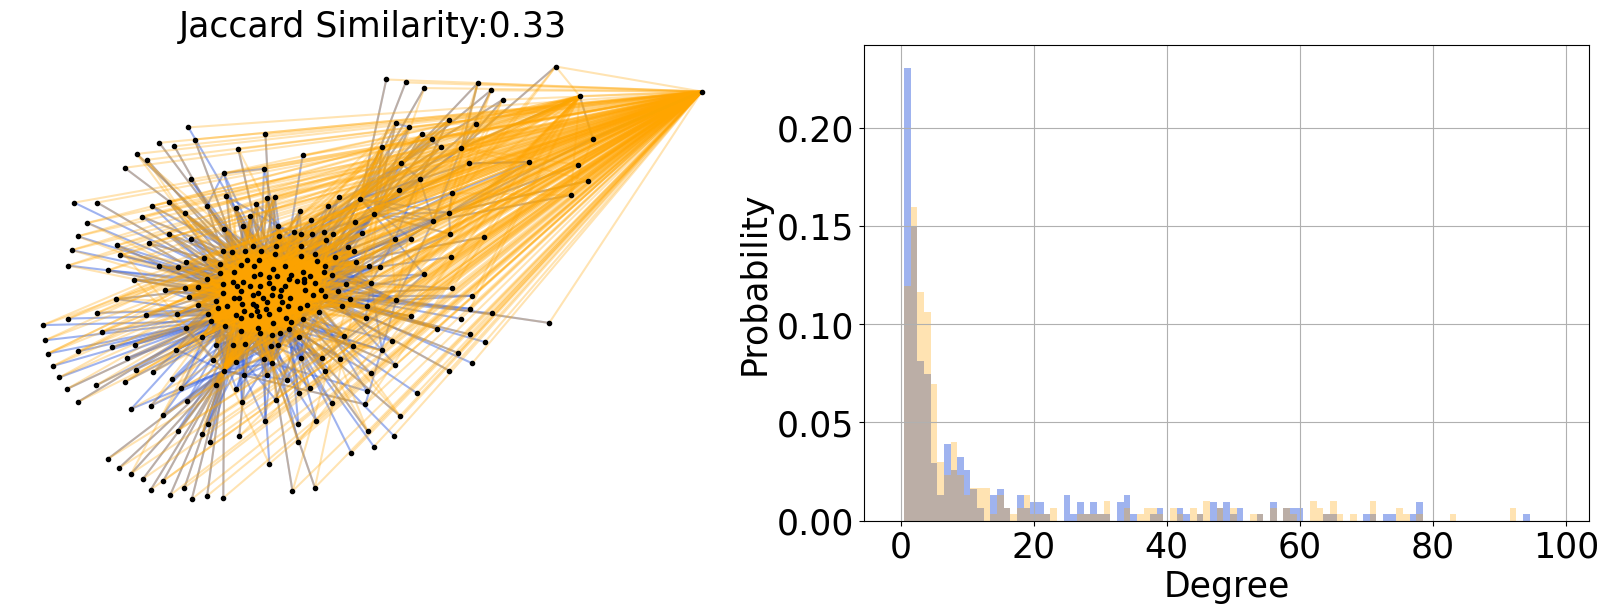

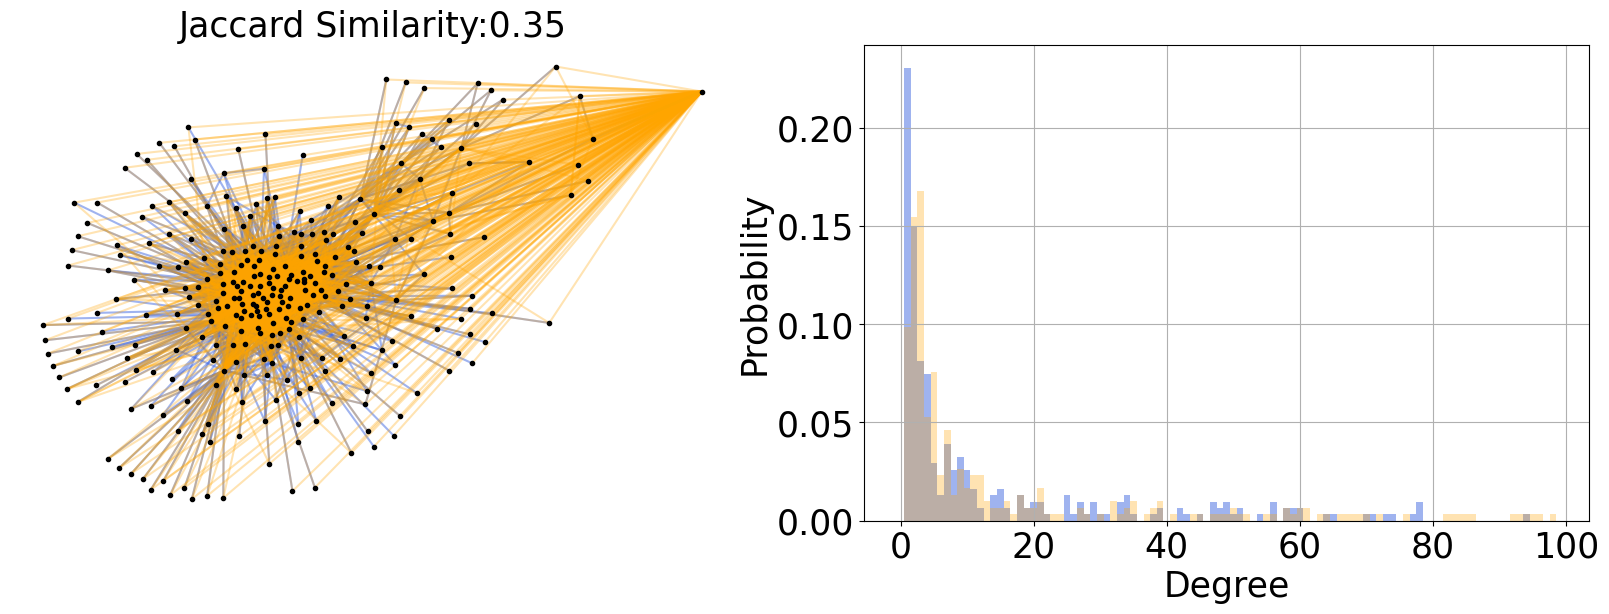

In [19]:

def save_G_to_file(G, fileName):
    file_path = "graphs/"+fileName+".npy"
    # Save the matrix to a file
    np.save(file_path, nx.to_numpy_array(G))
    print(f"NumPy matrix saved to file: {file_path}")
fixMin= 0
fixMax= 100

graphAnp= Aws[i]*100
graphA= nx.from_numpy_matrix(graphAnp)
pos = nx.spring_layout(graphA, k= 100/graphAnp.shape[0], iterations= 200, seed= 1)

for i, _ in enumerate(PreAs):
    PreAsp= continious_to_sparcity(PreAs[i], links[i])
    graphPreA = nx.from_numpy_matrix(PreAsp)
    graphAnp= Aws[i]*100
    graphA= nx.from_numpy_matrix(graphAnp)
    # save_G_to_file(graphPreA, realGraphs3[i]+"_pre")
    # pos= plotGraph.read_posDic_from_json(f"jsons/{realGraphs3[i]}_coord_dict.json")
    # mapping= {j: int(mappings[i][j]) for j in mappings[i]}
    # graphA=nx.relabel_nodes(graphA, mapping)
    # graphPreA=nx.relabel_nodes(graphPreA, mapping)
    plotGraph.plot_spring_and_degree(graphA, graphPreA, pos, fixMin, fixMax, stringT= f"Jaccard Similarity:{jaccardSims[i]}")